Epoch 1/10
110/110 [==============================] - 6s 12ms/step - loss: 0.0663
Epoch 2/10
110/110 [==============================] - 1s 7ms/step - loss: 0.0200
Epoch 3/10
110/110 [==============================] - 1s 7ms/step - loss: 0.0184
Epoch 4/10
110/110 [==============================] - 1s 8ms/step - loss: 0.0180
Epoch 5/10
110/110 [==============================] - 1s 8ms/step - loss: 0.0158
Epoch 6/10
110/110 [==============================] - 1s 8ms/step - loss: 0.0153
Epoch 7/10
110/110 [==============================] - 1s 12ms/step - loss: 0.0140
Epoch 8/10
110/110 [==============================] - 1s 12ms/step - loss: 0.0153
Epoch 9/10
110/110 [==============================] - 1s 8ms/step - loss: 0.0140
Epoch 10/10
22/22 [==============================] - 0s 3ms/step
Accuracy: 0.9869753979739508
Recall: 0.9985228951255539
F1-score: 0.9933872152828803
ROC AUC: 0.7135471618484913
Error Rate: 0.013024602026049159


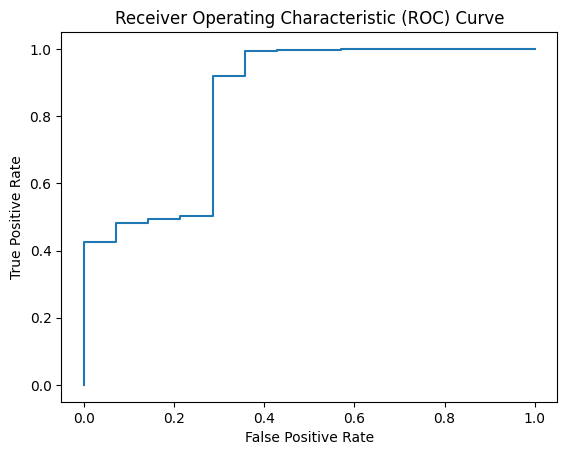

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Charger les données d'entraînement et de test
train_path = "TrainDataset.csv"
test_path = "TestDataset.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Supprimer les deux premières lignes contenant les noms des colonnes et les unités de mesure
train_data = train_data.iloc[2:]
test_data = test_data.iloc[2:]

# Convertir les données en tableau numpy (en excluant la première colonne de temps)
train_values = train_data.iloc[:, 1:].values
test_values = test_data.iloc[:, 1:].values

# Convertir les valeurs de classe en codage binaire (0 pour "Normal" et 1 pour "critique")
label_encoder = LabelEncoder()
train_values[:, -1] = label_encoder.fit_transform(train_values[:, -1])
test_values[:, -1] = label_encoder.transform(test_values[:, -1])

# Convertir les valeurs en float
train_values = train_values.astype(float)
test_values = test_values.astype(float)

# Diviser les données en variables d'entrée (X) et variable de sortie (y)
X_train = train_values[:, :-1]  # Toutes les colonnes sauf la dernière (classe)
y_train = train_values[:, -1]  # Dernière colonne (classe)

X_test = test_values[:, :-1]  # Toutes les colonnes sauf la dernière (classe)
y_test = test_values[:, -1]  # Dernière colonne (classe)

# Normaliser les données
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Préparer les données en séquences pour le modèle RNN
sequence_length = 10  # Longueur de la séquence
X_train_sequences = []
y_train_sequences = []

for i in range(sequence_length, len(X_train_scaled)):
    X_train_sequences.append(X_train_scaled[i - sequence_length:i])
    y_train_sequences.append(y_train[i])

X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)

# Créer le modèle RNN
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')

# Entraîner le modèle
model.fit(X_train_sequences, y_train_sequences, epochs=10, batch_size=32)

# Préparer les données de test en séquences pour les prédictions
X_test_sequences = []

for i in range(sequence_length, len(X_test_scaled)):
    X_test_sequences.append(X_test_scaled[i - sequence_length:i])

X_test_sequences = np.array(X_test_sequences)

# Faire les prédictions
y_pred = model.predict(X_test_sequences)
y_pred_classes = np.round(y_pred).flatten()

# Calculer les mesures de performance
accuracy = accuracy_score(y_test[sequence_length:], y_pred_classes)
recall = recall_score(y_test[sequence_length:], y_pred_classes)
f1 = f1_score(y_test[sequence_length:], y_pred_classes)
roc_auc = roc_auc_score(y_test[sequence_length:], y_pred_classes)
error_rate = 1 - accuracy

# Afficher les mesures de performance
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC AUC:", roc_auc)
print("Error Rate:", error_rate)

# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test[sequence_length:], y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()
